Imports

In [3]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU
from keras.layers import LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#hyperparameters

steps_in_the_future = 50

Getting the data

In [5]:
import os
path_to_data = os.path.join("..", "ProcessingData", "BTC Minute CSVs", "BTCUSER_all_processed.parquet")
df = pd.read_parquet(path_to_data, engine='fastparquet')

In [3]:
# df = pd.read_csv("gemini_BTCUSD_2021_1min.csv")

In [6]:
indexes = [i for i in range(0, len(df)) if i % (30) == 0]
indexes

[0,
 30,
 60,
 90,
 120,
 150,
 180,
 210,
 240,
 270,
 300,
 330,
 360,
 390,
 420,
 450,
 480,
 510,
 540,
 570,
 600,
 630,
 660,
 690,
 720,
 750,
 780,
 810,
 840,
 870,
 900,
 930,
 960,
 990,
 1020,
 1050,
 1080,
 1110,
 1140,
 1170,
 1200,
 1230,
 1260,
 1290,
 1320,
 1350,
 1380,
 1410,
 1440,
 1470,
 1500,
 1530,
 1560,
 1590,
 1620,
 1650,
 1680,
 1710,
 1740,
 1770,
 1800,
 1830,
 1860,
 1890,
 1920,
 1950,
 1980,
 2010,
 2040,
 2070,
 2100,
 2130,
 2160,
 2190,
 2220,
 2250,
 2280,
 2310,
 2340,
 2370,
 2400,
 2430,
 2460,
 2490,
 2520,
 2550,
 2580,
 2610,
 2640,
 2670,
 2700,
 2730,
 2760,
 2790,
 2820,
 2850,
 2880,
 2910,
 2940,
 2970,
 3000,
 3030,
 3060,
 3090,
 3120,
 3150,
 3180,
 3210,
 3240,
 3270,
 3300,
 3330,
 3360,
 3390,
 3420,
 3450,
 3480,
 3510,
 3540,
 3570,
 3600,
 3630,
 3660,
 3690,
 3720,
 3750,
 3780,
 3810,
 3840,
 3870,
 3900,
 3930,
 3960,
 3990,
 4020,
 4050,
 4080,
 4110,
 4140,
 4170,
 4200,
 4230,
 4260,
 4290,
 4320,
 4350,
 4380,
 4410,
 44

In [7]:
temp = df.iloc[indexes]
temp = temp.loc[df['Date'] > '2019-06-01 00:00:00']
df = temp
df

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume,RSI_14,SMA_50,MACD_12_26_9
1871730,1559347800000,2019-06-01 00:10:00,BTCUSD,8516.20,8516.20,8516.20,8516.20,0.000000,87.636197,8310.7898,65.091441
1871760,1559349600000,2019-06-01 00:40:00,BTCUSD,8516.20,8516.20,8516.20,8516.20,0.000000,87.636197,8456.2454,12.909937
1871790,1559351400000,2019-06-01 01:10:00,BTCUSD,8516.20,8516.20,8516.20,8516.20,0.000000,87.636197,8516.2000,1.325855
1871820,1559353200000,2019-06-01 01:40:00,BTCUSD,8516.20,8516.20,8516.20,8516.20,0.000000,87.636197,8516.2000,0.132046
1871850,1559355000000,2019-06-01 02:10:00,BTCUSD,8516.20,8516.20,8516.20,8516.20,0.000000,87.636197,8516.2000,0.013124
...,...,...,...,...,...,...,...,...,...,...,...
3134280,1638653820000,2021-12-04 21:37:00,BTCUSD,48916.50,48945.69,48908.45,48945.69,0.081272,46.588652,49098.2736,-53.481470
3134310,1638655620000,2021-12-04 22:07:00,BTCUSD,48705.18,48740.92,48705.18,48738.07,0.580081,45.390891,48840.8440,-34.973777
3134340,1638657420000,2021-12-04 22:37:00,BTCUSD,49133.94,49133.94,49059.62,49059.62,0.412475,59.558635,48814.4160,93.711965
3134370,1638659220000,2021-12-04 23:07:00,BTCUSD,49411.09,49517.02,49390.61,49484.96,4.048899,70.044854,49056.9276,107.848213


In [8]:
important_columns = ['Close'] #modify this to add other columns like RSI, Moving Average etc
important_data = df[important_columns]
important_data

,Close
1871730,8516.20
1871760,8516.20
1871790,8516.20
1871820,8516.20
1871850,8516.20
...,...
3134280,48945.69
3134310,48738.07
3134340,49059.62
3134370,49484.96


Processing the data to make for training

In [9]:
data_values = important_data['Close'].astype('float32')
train_scl = data_values[0:int(len(data_values) * 0.80)]
scl = MinMaxScaler()

scl.fit(train_scl.values.reshape(-1, 1))
data_values = scl.transform(data_values.values.reshape(-1, 1))
data_values

array([[0.0704717 ],
       [0.0704717 ],
       [0.0704717 ],
       ...,
       [0.7389783 ],
       [0.7459916 ],
       [0.74105555]], dtype=float32)

In [10]:
def process_data(data,lb):
    X,Y = [],[]
    for i in range(len(data)-lb-steps_in_the_future):
        X.append(data[i:(i+lb),0])
        Y.append(data[(i+lb):(i+lb+steps_in_the_future),0])
    return np.array(X),np.array(Y)

lb = 50
X, Y = process_data(data_values, lb)
split = 80 # how much should it be used for training and how much for testing?
X_train, X_test = X[:int(X.shape[0]*split)],X[int(X.shape[0]*split):]
Y_train, Y_test = Y[:int(Y.shape[0]*split)],Y[int(Y.shape[0]*split):]
# X_test = X
# Y_test = Y
# X_test_all = np.copy(X_test)
# X_test = X[0]
# X_test = np.atleast_2d(X_test)
# X_test

Building the model

In [11]:
# model = Sequential()
# model.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (lb, 1)))
# model.add(Dropout(0.2))
# model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
# model.add(Dropout(0.3))
# model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
# model.add(Dropout(0.4))
# model.add(LSTM(units = 120, activation = 'relu'))
# model.add(Dropout(0.5))
# model.add(Dense(units =1))
# model.compile(loss='mse')

# model = Sequential()
# model.add(LSTM(units=50, activation='tanh', input_shape=(lb, 1), return_sequences=False))
# model.add(Dropout(0.8))
# # model.add(LSTM(units=60, activation='tanh', return_sequences=False))
# # model.add(Dropout(0.8))
# model.add(Dense(1))
# model.add(LeakyReLU())
# model.compile(optimizer=Adam(), loss='mse')

model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(lb, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=steps_in_the_future))
model.compile(loss='mean_squared_error', optimizer='adam')

In [13]:
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
# X_test_reshaped = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

In [14]:
history = model.fit(X_train,Y_train,epochs=50,validation_data=(X_test,Y_test),shuffle=False)

model.save('Models\\model2')
model.summary()

Epoch 1/50
1313/1313 [==============================] - 239s 168ms/step - loss: 0.0016
Epoch 2/50
1313/1313 [==============================] - 221s 168ms/step - loss: 0.0046
Epoch 3/50
1313/1313 [==============================] - 249s 189ms/step - loss: 0.0074
Epoch 4/50
1313/1313 [==============================] - 211s 161ms/step - loss: 0.0063
Epoch 5/50
1313/1313 [==============================] - 207s 158ms/step - loss: 0.0053
Epoch 6/50
1313/1313 [==============================] - 201s 153ms/step - loss: 0.0070
Epoch 7/50
1313/1313 [==============================] - 217s 165ms/step - loss: 0.0068
Epoch 8/50
1313/1313 [==============================] - 203s 155ms/step - loss: 0.0059
Epoch 9/50
1313/1313 [==============================] - 203s 155ms/step - loss: 0.0064
Epoch 10/50
1313/1313 [==============================] - 206s 157ms/step - loss: 0.0068
Epoch 11/50
1313/1313 [==============================] - 207s 158ms/step - loss: 0.0066
Epoch 12/50
1313/1313 [==================

INFO:tensorflow:Assets written to: Models\model2\assets


INFO:tensorflow:Assets written to: Models\model2\assets


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 96)            37632     
                                                                 
 dropout (Dropout)           (None, 50, 96)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 96)            74112     
                                                                 
 dropout_1 (Dropout)         (None, 50, 96)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50, 96)            74112     
                                                                 
 dropout_2 (Dropout)         (None, 50, 96)            0         
                                                                 
 lstm_3 (LSTM)               (None, 96)                7

In [10]:
plt.figure(figsize=(12,8))

Xt = model.predict(X_test)
plt.plot(scl.inverse_transform(Y_test.reshape(-1,1)), label="Actual")
plt.plot(scl.inverse_transform(Xt), label="Predicted")
plt.legend()
plt.title("Train Dataset")

NameError: name 'model' is not defined

<Figure size 864x576 with 0 Axes>

In [12]:
np.mean(np.abs((Xt / Y_test) - 1))

0.15307137

In [13]:
differences = np.abs((Xt.reshape((1,Xt.shape[0])) / Y_test.reshape((1,Y_test.shape[0]))) - 1)
print(f'Mean: {np.mean(differences)}\n'
      f'Std: {np.std(differences)}\n'
      f'Max: {np.max(differences)}\n'
      f'Min: {np.min(differences)}\n')

Mean: 0.07902240008115768
Std: 0.04070517420768738
Max: 0.15440315008163452
Min: 8.791685104370117e-05



In [44]:
X_test_reshaped

array([[[0.32189322],
        [0.2852211 ],
        [0.26767302],
        [0.27481604],
        [0.27056694],
        [0.2832694 ],
        [0.27530193],
        [0.29680538],
        [0.26192474],
        [0.27088833],
        [0.30862665],
        [0.29533195],
        [0.329988  ],
        [0.28056383],
        [0.26733637],
        [0.2846403 ],
        [0.25640154],
        [0.24003267],
        [0.20287228],
        [0.1976862 ],
        [0.220613  ],
        [0.20711088],
        [0.22323418],
        [0.23114204],
        [0.17881918],
        [0.1937375 ],
        [0.1996026 ],
        [0.18037271],
        [0.25739384],
        [0.22682047],
        [0.22798252],
        [0.2483468 ],
        [0.23330307],
        [0.2064066 ],
        [0.21083832],
        [0.23158932],
        [0.23618603],
        [0.2928524 ],
        [0.1633234 ],
        [0.16052675],
        [0.18616533],
        [0.1845479 ],
        [0.17398071],
        [0.17832279],
        [0.17985725],
        [0

In [111]:
from keras.models import load_model
modelBianca = load_model('Models\\stock_prediction.h5')

plt.figure(figsize=(12,8))

Xt = modelBianca.predict(X_test_all)
Xt


array([[0.14019711],
       [0.15898001],
       [0.14714043],
       ...,
       [1.0320972 ],
       [1.0330706 ],
       [1.0291232 ]], dtype=float32)

<Figure size 864x576 with 0 Axes>

In [98]:
def shift_left(array, new_value):
    array = np.roll(array, -1)
    array[0, array.shape[1] - 1] = new_value
    return array

Xcopy = np.copy(X_test)
shift_left(Xcopy, 1231)
# Xcopy.shape
# np.roll(Xcopy, -1)
Xcopy

array([[0.32189322, 0.2852211 , 0.26767302, ..., 0.10785818, 0.10672569,
        0.127738  ],
       [0.2852211 , 0.26767302, 0.27481604, ..., 0.10672569, 0.127738  ,
        0.1157341 ],
       [0.26767302, 0.27481604, 0.27056694, ..., 0.127738  , 0.1157341 ,
        0.10974932],
       ...,
       [1.8147864 , 1.8124213 , 1.8390603 , ..., 1.837892  , 1.8632083 ,
        1.7889247 ],
       [1.8124213 , 1.8390603 , 1.810617  , ..., 1.8632083 , 1.7889247 ,
        1.824224  ],
       [1.8390603 , 1.810617  , 1.7884622 , ..., 1.7889247 , 1.824224  ,
        1.8445659 ]], dtype=float32)

In [114]:
results = []
X_test_copy = np.copy(X_test)
for i in range(0, 50):
    print(f'{i} / {Y_test.shape[0]}')
    Xt = modelBianca(X_test_copy)
    results.append(np.copy(Xt))
    X_test_copy = shift_left(X_test_copy, Xt[0, 0])
    print('a')
    # X_test_reshaped = X_test_copy.reshape((X_test_copy.shape[0],X_test_copy.shape[1],1))

0 / 1485
a
1 / 1485
a
2 / 1485
a
3 / 1485
a
4 / 1485
a
5 / 1485
a
6 / 1485
a
7 / 1485
a
8 / 1485
a
9 / 1485
a
10 / 1485
a
11 / 1485
a
12 / 1485
a
13 / 1485
a
14 / 1485
a
15 / 1485
a
16 / 1485
a
17 / 1485
a
18 / 1485
a
19 / 1485
a
20 / 1485
a
21 / 1485
a
22 / 1485
a
23 / 1485
a
24 / 1485
a
25 / 1485
a
26 / 1485
a
27 / 1485
a
28 / 1485
a
29 / 1485
a
30 / 1485
a
31 / 1485
a
32 / 1485
a
33 / 1485
a
34 / 1485
a
35 / 1485
a
36 / 1485
a
37 / 1485
a
38 / 1485
a
39 / 1485
a
40 / 1485
a
41 / 1485
a
42 / 1485
a
43 / 1485
a
44 / 1485
a
45 / 1485
a
46 / 1485
a
47 / 1485
a
48 / 1485
a
49 / 1485
a


In [117]:
results = np.array(results)

In [119]:
Xt = modelBianca.predict(X_test_all)

Text(0.5, 1.0, 'Train Dataset Bianca')

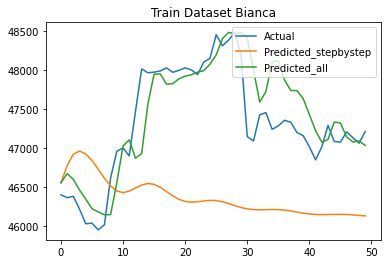

In [121]:
# results
# for i in range(0, len(results)):
#     results[i] = np.array(results[i])

plt.plot(scl.inverse_transform(Y_test[:50].reshape(-1,1)), label="Actual")
plt.plot(scl.inverse_transform(results.reshape(-1,1)), label="Predicted_stepbystep")
plt.plot(scl.inverse_transform(Xt[:50].reshape(-1,1)), label="Predicted_all")
plt.legend()
plt.title("Train Dataset Bianca")

In [97]:
Y_test, results

(array([0.1157341 , 0.10974932, 0.1126194 , ..., 1.824224  , 1.8445659 ,
        1.9140754 ], dtype=float32),
 array([[0.14019711],
        [0.15898001],
        [0.14714043],
        ...,
        [1.0320972 ],
        [1.0330706 ],
        [1.0291232 ]], dtype=float32))